In [1]:
import os
import sys
import inspect
import torch
from torchvision import transforms, utils
import torchvision.transforms.functional as TF
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numba
import PyKDL

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.append(currentdir)
sys.path.append(parentdir)

from models.unet import UNet
from utils.util_functions import get_normals_from_depth, rotation_between_normals, rotation_to_euler_zyx

In [2]:
def load_model(path):
    model = UNet(n_channels=3, n_classes=3, bilinear=False)
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    return model


def create_circular_mask(h, w, center=None, radius=None):
    # https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

## Plot the results of the model and Realsense camera

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 1min 42s, sys: 11.8 s, total: 1min 54s
Wall time: 26.4 s


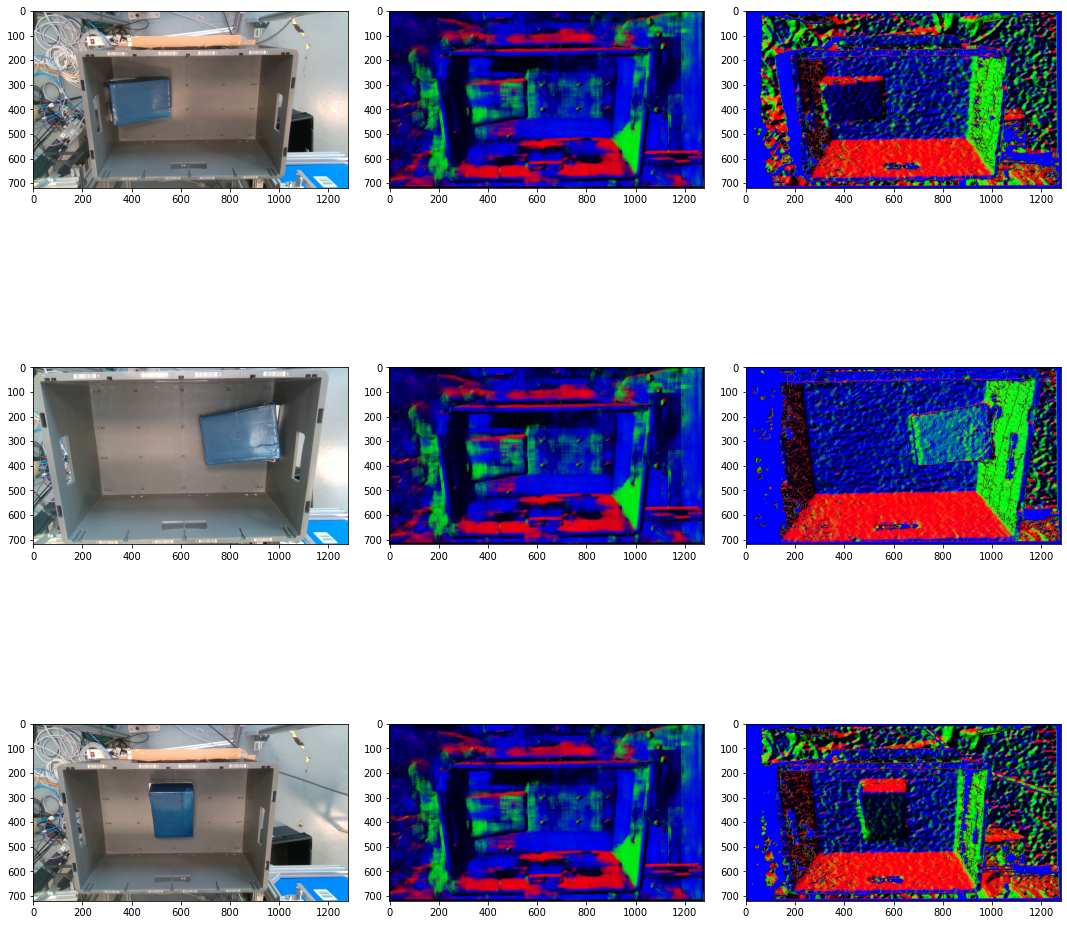

In [3]:
%%time

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.tight_layout()

BASE_PATH = '../images/experiment_on_robot/'
img1 = Image.open(BASE_PATH + 'item_left_images/item_left_height_1.png')
img1 = np.array(img1)
axes[0][0].imshow(img1)
img1 = torch.from_numpy(img1.astype(np.float32)).permute(2, 0, 1)
depth1 = np.array(
    Image.open(BASE_PATH + 'item_left_images/true_depth_item_left_height_1.png'), dtype=np.float32)
axes[0][2].imshow(get_normals_from_depth(depth1))

img2 = Image.open('../images/source_right_blue.png')
img2 = np.array(img2)
axes[1][0].imshow(img2)
img2 = torch.from_numpy(img2.astype(np.float32)).permute(2, 0, 1)
depth2 = np.array(Image.open(
    '../images/depth_source_right_blue.png'), dtype=np.float32)
axes[1][2].imshow(get_normals_from_depth(depth2))

img3 = Image.open(BASE_PATH + 'item_top_images/item_top_height_1.png')
img3 = np.array(img3)
axes[2][0].imshow(img3)
img3 = torch.from_numpy(img3.astype(np.float32)).permute(2, 0, 1)
depth3 = np.array(
    Image.open(BASE_PATH + 'item_top_images/true_depth_item_top_height_1.png'), dtype=np.float32)
axes[2][2].imshow(get_normals_from_depth(depth3))

model = load_model(path='../models/saved_models/new_model_3_33000.pth')

pred_img1 = model(img1.view(-1, *img1.shape))[0].detach().permute(1, 2, 0).numpy()
pred_img2 = model(img2.view(-1, *img2.shape))[0].detach().permute(1, 2, 0).numpy()
pred_img3 = model(img3.view(-1, *img3.shape))[0].detach().permute(1, 2, 0).numpy()

normals1 = get_normals_from_depth(depth1)
normals2 = get_normals_from_depth(depth2)
normals3 = get_normals_from_depth(depth3)

axes[0][1].imshow(pred_img1)
axes[0][2].imshow(normals1)

axes[1][1].imshow(pred_img1)
axes[1][2].imshow(normals2)

axes[2][1].imshow(pred_img1)
axes[2][2].imshow(normals3)

# Image 1

In [4]:
import cv2

In [5]:
grasp_x = 462
grasp_y = 358

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


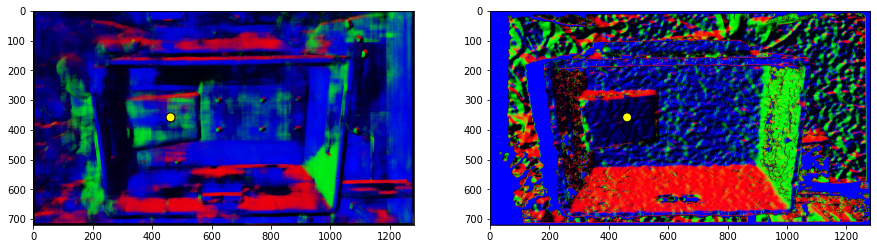

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

circle1 = plt.Circle((grasp_x, grasp_y), radius=15, edgecolor='black', facecolor='yellow')
circle2 = plt.Circle((grasp_x, grasp_y), radius=15, edgecolor='black', facecolor='yellow')

ax[0].add_patch(circle1)
ax[1].add_patch(circle2)

ax[0].imshow(pred_img1)
ax[1].imshow(normals1)

### Test if masking the pick point works

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


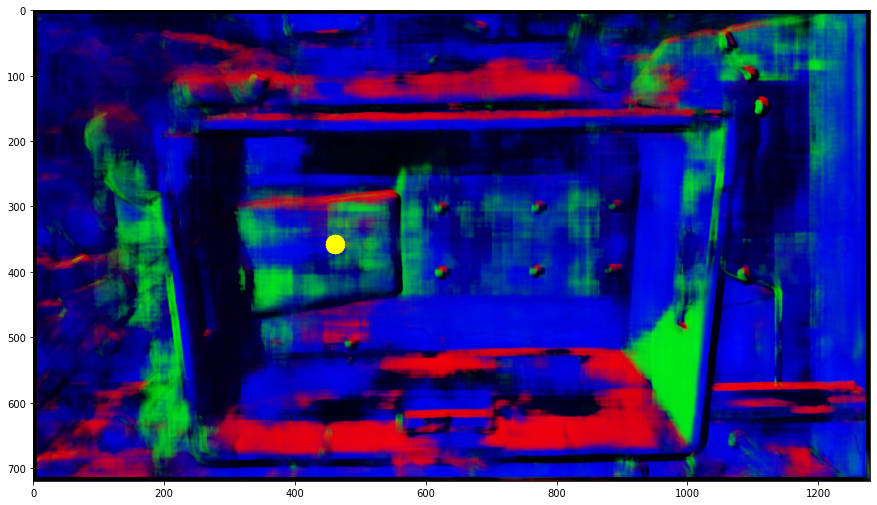

In [7]:
mask = create_circular_mask(*pred_img1.shape[:2], center=(grasp_x, grasp_y), radius=15)

new_img = pred_img1.copy()
new_img[mask] = (1, 1, 0)  # paint mask in yellow
plt.figure(figsize=(15, 15))
plt.imshow(new_img)

## Check rotation of the item

### From prediction

In [32]:
print('Vector in grasp point: ', pred_img1[grasp_y, grasp_x])

r = 15
mask = create_circular_mask(*pred_img1.shape[:2], center=(grasp_x, grasp_y), radius=r)
print(f'Mean vector from {r} points: ', pred_img1[mask].mean(axis=0))

Vector in grasp point:  [0.157685   0.5149295  0.28289172]
Mean vector from 15 points:  [0.10028166 0.21982804 0.5459321 ]


In [10]:
rotation_grasp_point = rotation_between_normals(
    a=np.array([0, 0, -1], dtype=np.float32),  # Robot tool
    b=-pred_img1[grasp_y, grasp_x],
)

rotation_mean = rotation_between_normals(
    a=np.array([0, 0, -1], dtype=np.float32),  # Robot tool
    b=-pred_img1[mask].mean(axis=0),
)

print('Rotation in Euler ZYX in grasp point pixel: ', rotation_to_euler_zyx(rotation_grasp_point))
print('Rotation in Euler ZYX from mean around grasp point pixels: ', rotation_to_euler_zyx(rotation_mean))

Rotation in Euler ZYX in grasp point pixel:  (-8.921063555502466, 15.023601122752407, -61.2165058333826)
Rotation in Euler ZYX from mean around grasp point pixels:  (-1.8780727547595142, 9.669971814132973, -21.93294500648349)


### From Realsense depth

In [33]:
print('Vector in grasp point: ', normals1[grasp_y, grasp_x])

r = 15
mask = create_circular_mask(*normals1.shape[:2], center=(grasp_x, grasp_y), radius=r)
print(f'Mean vector from {r} points: ', normals1[mask].mean(axis=0))

Vector in grasp point:  [-0.70014006 -0.70014006  0.14002801]
Mean vector from 15 points:  [-0.27506587 -0.6686126   0.31223637]


In [28]:
rotation_grasp_point = rotation_between_normals(
    a=np.array([0, 0, -1], dtype=np.float32),  # Robot tool
    b=-normals1[grasp_y, grasp_x],
)

rotation_mean = rotation_between_normals(
    a=np.array([0, 0, -1], dtype=np.float32),  # Robot tool
    b=-normals1[mask].mean(axis=0),
)

print('Rotation in Euler ZYX in grasp point pixel: ', rotation_to_euler_zyx(rotation_grasp_point))
print('Rotation in Euler ZYX from mean around grasp point pixels: ', rotation_to_euler_zyx(rotation_mean))

Rotation in Euler ZYX in grasp point pixel:  (-37.028817770932015, -44.43824151096832, 78.69007069703187)
Rotation in Euler ZYX from mean around grasp point pixels:  (-13.098216791381482, -20.44321562956184, 64.96782573240668)


# Image 2

In [62]:
grasp_x = 845
grasp_y = 293

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


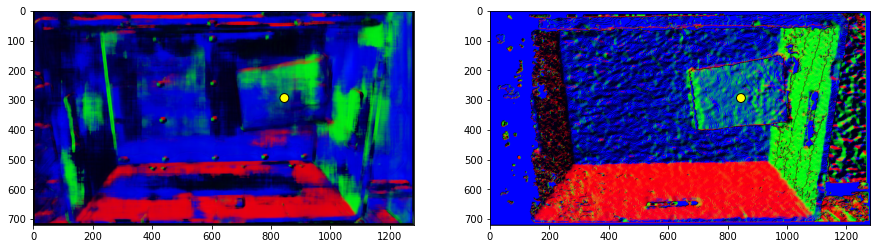

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

circle1 = plt.Circle((grasp_x, grasp_y), radius=15, edgecolor='black', facecolor='yellow')
circle2 = plt.Circle((grasp_x, grasp_y), radius=15, edgecolor='black', facecolor='yellow')

ax[0].add_patch(circle1)
ax[1].add_patch(circle2)

ax[0].imshow(pred_img2)
ax[1].imshow(normals2)

## Check rotation of the item

### From prediction

In [64]:
print('Vector in grasp point: ', pred_img2[grasp_y, grasp_x])

r = 15
mask = create_circular_mask(*pred_img2.shape[:2], center=(grasp_x, grasp_y), radius=r)
print(f'Mean vector from {r} points: ', pred_img2[mask].mean(axis=0))

Vector in grasp point:  [-0.04100271  0.18453203  0.58141816]
Mean vector from 15 points:  [-0.02401908  0.30421     0.49140608]


In [65]:
rotation_grasp_point = rotation_between_normals(
    a=np.array([0, 0, -1], dtype=np.float32),  # Robot tool
    b=-pred_img2[grasp_y, grasp_x],
)

rotation_mean = rotation_between_normals(
    a=np.array([0, 0, -1], dtype=np.float32),  # Robot tool
    b=-pred_img2[mask].mean(axis=0),
)

print('Rotation in Euler ZYX in grasp point pixel: ', rotation_to_euler_zyx(rotation_grasp_point))
print('Rotation in Euler ZYX from mean around grasp point pixels: ', rotation_to_euler_zyx(rotation_mean))

Rotation in Euler ZYX in grasp point pixel:  (0.5958267147271381, -3.8455017896567463, -17.608534351191796)
Rotation in Euler ZYX from mean around grasp point pixels:  (0.6770956563069491, -2.379800671961288, -31.760007444719903)


### From Realsense Depth

In [66]:
print('Vector in grasp point: ', normals2[grasp_y, grasp_x])

r = 15
mask = create_circular_mask(*normals2.shape[:2], center=(grasp_x, grasp_y), radius=r)
print(f'Mean vector from {r} points: ', normals2[mask].mean(axis=0))

Vector in grasp point:  [-0. -0.  1.]
Mean vector from 15 points:  [-0.12347366  0.39737102  0.5974534 ]


In [67]:
rotation_grasp_point = rotation_between_normals(
    a=np.array([0, 0, -1], dtype=np.float32),  # Robot tool
    b=-normals2[grasp_y, grasp_x],
)

rotation_mean = rotation_between_normals(
    a=np.array([0, 0, -1], dtype=np.float32),  # Robot tool
    b=-normals2[mask].mean(axis=0),
)

print('Rotation in Euler ZYX in grasp point pixel: ', rotation_to_euler_zyx(rotation_grasp_point))
print('Rotation in Euler ZYX from mean around grasp point pixels: ', rotation_to_euler_zyx(rotation_mean))

Rotation in Euler ZYX in grasp point pixel:  (0.0, -0.0, 0.0)
Rotation in Euler ZYX from mean around grasp point pixels:  (2.9570130619250268, -9.763872282314884, -33.628196598167406)
